In [1]:
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import os
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import init
import warnings
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from losses import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import make_axes_locatable
def number_of_features_per_level(init_channel_number, num_levels):
    """Return a list of features, doubling in size depending on the num_levels.
    Args:
        init_channel_number (int): initial channel number
        num_levels (int): number of levels of the deep network
    Returns:
        list of features (lists)
    eg. number_of_features_per_level(64,4) -> [64,128,256,512]
    """
    return [init_channel_number * 2 ** k for k in range(num_levels)]

class SELayer(nn.Module):#se+res
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
        self.relu=nn.ReLU(inplace=True)

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        out=x * y.expand_as(x)+x
        out=self.relu(out)
        return out
class SingleConv(nn.Module):
    # Convolution + Batch Norm + ReLU

    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, stride=1, num_groups=8, activation=True):
        super(SingleConv, self).__init__()

        if out_channels < num_groups:
            num_groups = 1

        if activation:
            # use only one group if the given number of groups is greater than the number of channels
            self.singleconv = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
                nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
                nn.ELU(inplace=True)
            )
        else:
            self.singleconv = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding,stride=stride, bias=False),
                nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            )

    def forward(self, x):
        return self.singleconv(x)


class Downsampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsampling, self).__init__()

        self.conv1 = SingleConv(in_channels, out_channels, 1, padding=0, stride=2)
        self.conv2 = SingleConv(in_channels, out_channels, 3, padding=1, stride=2)
        self.conv3 = SingleConv(in_channels, out_channels, 5, padding=2, stride=2)

    def forward(self,x):

        down1 = self.conv1(x) + self.conv2(x) + self.conv3(x)
        # down2 = self.conv1(down1) + self.conv2(down1) + self.conv3(down1)

        return down1
        

class AttBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttBlock,self).__init__()
        self.W_g = SingleConv(F_g, F_int, kernel_size=1, padding=0, activation=False)
        
        self.W_x = SingleConv(F_l, F_int, kernel_size=1, padding=0, activation=False)

        self.psi = SingleConv(F_int, 1, kernel_size=1, padding=0, activation=False)
        
        self.sigmoid = nn.Sigmoid()

        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        psi = self.sigmoid(psi)

        return x*psi



class RRCU(nn.Module):
    # Recurrent Residual Convolutional Unit

    def __init__(self, out_channels, t=2, kernel_size=3, **kwargs):
        super(RRCU, self).__init__()

        self.t = t

        self.conv = SingleConv(out_channels, out_channels, kernel_size=kernel_size)
    def forward(self,x):

        for i in range(self.t):
            if i == 0:
                x1 = self.conv(x) 
            x1 = self.conv(x1)

        return x1



class RRConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels ,t=2, kernel_size=3):
        super(RRConvBlock,self).__init__()
        #self.se=SELayer(in_channels)
        self.module = nn.Sequential(
            RRCU(out_channels=out_channels,t=t, kernel_size=kernel_size),
            SELayer(out_channels),
            RRCU(out_channels=out_channels,t=t, kernel_size=kernel_size),
            SELayer(out_channels)
        )

        self.Conv_1x1 = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self,x):

        x = self.Conv_1x1(x)
        x1 = self.module(x)

        return x+x1



class Encode(nn.Module):
    def __init__(self, in_channels, out_channels ,t=2, conv_kernel_size=3, pool_kernel_size=(1,2,2), pooling=True,attention=True):
        super(Encode,self).__init__()
        self.attention=attention
        self.pooling = pooling
        if pooling:
            self.maxpool = nn.MaxPool3d(kernel_size=pool_kernel_size)

        self.module = RRConvBlock(in_channels=in_channels, out_channels=out_channels, t=t, kernel_size=conv_kernel_size)
        self.se=SELayer(in_channels)
    def forward(self,x):
        if self.attention:
            pass
        if self.pooling:
            x = self.maxpool(x)

        x = self.module(x)

        return x



class Decode(nn.Module):
    def __init__(self, in_channels, out_channels, conv_kernel_size=3, scale_factor=(1, 2, 2),padding=1, mode="nearest", **kwargs):
        super(Decode, self).__init__()

        # self.upsample = InterpolateUpsampling(mode)
        self.upconv = nn.Sequential(
            nn.Upsample(scale_factor=scale_factor,mode=mode),
            SingleConv(in_channels, out_channels, kernel_size=conv_kernel_size, padding=padding)
        )
        
        self.att = AttBlock(out_channels, out_channels, out_channels//2)
        self.module = RRConvBlock(in_channels=out_channels, out_channels=out_channels, t=2, kernel_size=conv_kernel_size)

    
    def forward(self, encoder_features, x):

        upx = self.upconv(x)
        x = self.att(upx ,encoder_features)

       # Summation joining instead of concatenate
        x = encoder_features + x

        x = self.module(x)

        return x


class R2AttUNet3D(pl.LightningModule):  
    """Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`
    Based on the implementation of https://github.com/tbuikr/3D-SkipDenseSeg
    Paper here : https://arxiv.org/pdf/1709.03199.pdf
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        classes (int) - number of classification classes
    """

    def __init__(self,
                in_channels, 
                out_channels,  
                f_maps = [64,128,256,512],
                testing=False,
                batch_size=2,
                lr=5e-4,
                **kwargs):
        super(R2AttUNet3D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        if isinstance(f_maps, int):
            f_maps = number_of_features_per_level(f_maps, num_levels=4)

        assert isinstance(f_maps, list) or isinstance(f_maps, tuple)
        assert len(f_maps) > 1, "Required at least 2 levels in the U-Net"

        self.testing = testing
        self.final_activation = nn.Sigmoid()

        self.first_conv = Encode(in_channels, in_channels, pooling=False)

        self.downsample = Downsampling(in_channels, in_channels)

        self.down1 = Encode(in_channels, f_maps[0], pooling=False)
        self.down2 = Encode(f_maps[0], f_maps[1])
        self.down3 = Encode(f_maps[1], f_maps[2])
        self.down4 = Encode(f_maps[2], f_maps[3])
        
        self.up1 = Decode(f_maps[3], f_maps[2])
        self.up2 = Decode(f_maps[2], f_maps[1])
        self.up3 = Decode(f_maps[1], f_maps[0])

        self.upsample = nn.ConvTranspose3d(f_maps[0], out_channels, kernel_size=3, stride=2, padding=1)

        self.final_conv = nn.Conv3d(in_channels, out_channels, 1)
   
        self.num_batch = batch_size
        self.epoch = 0
        self.lr=lr
        self.history={"loss":[],"acc":[],"val_loss":[],"val_acc":[],"iou":[],"val_iou":[]}
        self.save_hyperparameters()        
    def forward(self, x):

        # print(x.shape)

        x1 = self.first_conv(x)
        # print(x1.shape)

        x = self.downsample(x)
        # print(x.shape)

        x2 = self.down1(x)
        # print(x2.shape)

        x3 = self.down2(x2)
        # print(x3.shape)

        x4 = self.down3(x3)
        # print(x4.shape)

        x5 = self.down4(x4)
        # print(x5.shape)


        x = self.up1(x4, x5)
        # print(x.shape)

        x = self.up2(x3, x)
        # print(x.shape)

        x = self.up3(x2, x)
        # print(x.shape)

        x = self.upsample(x, x1.size()[2:])
        # print(x.shape)

        x = x1 + x   

        y = self.final_conv(x)
        # print(y.shape)

        # apply final_activation (i.e. Sigmoid or Softmax) only during prediction. During training the network outputs
        if self.testing:
            y = self.final_activation(y)

        return y

    def configure_optimizers(self):
        optimizer = Adam(model.parameters(), lr=self.lr,eps=1e-4)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)
        #scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
        #return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs, labels = self.data_augment(inputs, labels, num_batch=self.num_batch)
        outputs = self(inputs)
        #loss=focal_tversky_loss(outputs,labels)
        loss1 = self.calc_loss(labels, outputs)
        loss2=GDiceloss(outputs,labels)
        loss=loss2
        #loss=Diceloss(outputs,labels)
        acc = self.binary_acc(labels, outputs)
        predicted_mask = outputs > 0.5
        #iou = iou_pytorch(predicted_mask.byte(), labels.squeeze(1).byte()).mean()
        iou=miou(outputs,labels)
        
        self.log("acc",acc,prog_bar=True)
        self.log("iou",iou,prog_bar=True)
        return {'loss': loss, 'acc': acc,'iou':iou}

    def training_epoch_end(self, outputs):#一轮数据训练结束时的操作。主要针对于本轮所有training_step的输出
        self.epoch += 1        
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc  = torch.stack([x['acc'] for x in outputs]).mean()
        avg_iou  = torch.stack([x['iou'] for x in outputs]).mean()
        print('Training (Epoch: ' + str(self.epoch) + ')')
        print('Loss: {:.4f}, Acc: {:.4f},iou:{:.4f}'.format(avg_loss, avg_acc,avg_iou))
        avg_loss_numpy=avg_loss.data.cpu().numpy()
        avg_acc_numpy=avg_acc.data.cpu().numpy()
        avg_iou_numpy=avg_iou.data.cpu().numpy()
        self.history["loss"].append(avg_loss_numpy)
        self.history["acc"].append(avg_acc_numpy)
        self.history["iou"].append(avg_iou_numpy)
        #logs = {'loss': avg_loss, 'acc': avg_acc}s
        #return {'loss': avg_loss, 'acc': avg_acc, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        inputs = torch.reshape(inputs, (self.num_batch,1,128,128,128))
        labels = torch.reshape(labels, (self.num_batch,1,128,128,128))        
        outputs = self(inputs)
        loss1 = self.calc_loss(labels, outputs)
        loss2=GDiceloss(outputs,labels)
        loss=loss2
        #loss=Diceloss(outputs,labels)
        #loss=focal_tversky_loss(outputs,labels)
        acc = self.binary_acc(labels, outputs)
        predicted_mask = outputs > 0.5
        #iou = iou_pytorch(predicted_mask.byte(), labels.squeeze(1).byte()).mean()
        iou=miou(outputs,labels)
        self.log("val_acc",acc,prog_bar=True)
        self.log("val_iou",iou,prog_bar=True)
        self.log("val_loss",loss,prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc,'val_iou':iou }

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc  = torch.stack([x['val_acc'] for x in outputs]).mean()
        avg_iou  = torch.stack([x['val_iou'] for x in outputs]).mean()        
        #logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        avg_loss_numpy=avg_loss.data.cpu().numpy()
        avg_acc_numpy=avg_acc.data.cpu().numpy()
        avg_iou_numpy=avg_iou.data.cpu().numpy()
        self.history["val_loss"].append(avg_loss_numpy)
        self.history["val_acc"].append(avg_acc_numpy)
        self.history["val_iou"].append(avg_iou_numpy)
        if self.epoch > 0:
            print('Validation (Epoch: ' + str(self.epoch) + ')')
            print('Loss: {:.4f}, Acc: {:.4f},iou:{:.4f}'.format(avg_loss, avg_acc,avg_iou))
        #return {'val_loss': avg_loss, 'log': logs}
    
    def calc_loss(self, labels, outputs):
        # Balanced Cross-Entropy
        count_pos = labels.sum()        # Fault
        count_neg = (1 - labels).sum()  # Non-fault
        beta = torch.as_tensor(count_neg / (count_neg + count_pos))
        pos_weight = torch.where(labels==1, beta / (1 - beta), torch.ones(1).cuda())
        loss = F.binary_cross_entropy_with_logits(outputs, labels, pos_weight=pos_weight)
        return loss * (1 - beta)
    
    def binary_acc(self, labels, outputs):
        y_pred_tag = torch.round(torch.sigmoid(outputs))
        correct_results_sum = torch.eq(y_pred_tag, labels).sum().float()
        acc = correct_results_sum / labels.shape.numel()
        return acc

    def data_augment(self, inputs, labels, num_batch, num_ch=1, num_aug=4, dim=(128,128,128)):
        #num_batch=num_batch/2#多GPU训练
        X = np.zeros([num_batch*num_aug, num_ch, *dim])
        Y = np.zeros([num_batch*num_aug, num_ch, *dim])

        for i in range(num_batch):
            for j in range(num_aug):
                X[num_aug*i+j,] = np.rot90(inputs[i,].cpu(),j,(0,1))
                Y[num_aug*i+j,] = np.rot90(labels[i,].cpu(),j,(0,1))

        inputs_aug = torch.from_numpy(X).float().reshape((num_batch*num_aug, num_ch, *dim))
        labels_aug = torch.from_numpy(Y).float().reshape((num_batch*num_aug, num_ch, *dim))
        return inputs_aug.cuda(), labels_aug.cuda()

In [2]:

model=R2AttUNet3D(in_channels=1,out_channels=1,f_maps = [32,64,128,256])
model=model.load_from_checkpoint("/data/max/3d-nets/lightning_logs/R2-unet_se/2022.5.26/ce+Gdice/epoch=45-step=16146.ckpt")
#model=model.load_from_checkpoint("/data/max/3d-nets/lightning_logs/R2-unet_se/2022.6.14/学习率8e-4_944_ce+Gdice/epoch=48-step=19648.ckpt")
#model=model.load_from_checkpoint("/data/max/3d-nets/lightning_logs/R2-unet_se/2022.5.26/学习率e-4_844_se_CE/epoch=47-step=16847.ckpt")
#model=model.load_from_checkpoint("/data/max/3d-nets/lightning_logs/R2-unet_se/2022.7.1/学习率8e-4_944_ce_v2/epoch=48-step=19648-v1.ckpt")

model=model.eval()

/home/max/.conda/envs/pytorch/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [21]:
import matplotlib.pyplot as plt
import copy
%matplotlib inline
seismPath = "./"
n3,n2,n1=512,384,128
f3 = np.load("/data/max/FaultNet-main/data/F3.npy").transpose((2, 1, 0))
#gx.tofile("f3.raw")
#gx = np.reshape(gx,(n3,n2,n1))
gx=copy.deepcopy(f3)
gm = np.mean(gx)
gs = np.std(gx)
gx = gx-gm
gx = gx/gs
#gx = np.transpose(gx)
a=np.reshape(gx,(1,1,n1,n2,n3))
#a=torch.tensor(a)
a=torch.tensor(a)
#a=a.half()
model.eval()
fp = model(a)
fp = torch.sigmoid(fp).detach().cpu().numpy()
fp=fp.squeeze()

In [22]:
def get_result_img (geo_slice, result_slice):
    hm = plt.get_cmap('bone')(geo_slice)[:, :, :-1]
    geo_slice = plt.get_cmap('seismic')(geo_slice)[:, :, :-1]
    logits = np.clip((result_slice[:, :, None]), a_min=0, a_max=1)
    colormap = plt.get_cmap('jet')(logits[:, :, 0])[:, :, :-1]
    hm = np.where(logits > 0.6, colormap, hm)
    return geo_slice, hm
def get_result_img_3d (fp, gx):
    hm = np.where(fp > 0.5, fp, gx)
    return hm
def get_result_img_(geo_slice, result_slice):
    hm = plt.get_cmap('bone')(geo_slice)[:, :,:,:-1]
    geo_slice = plt.get_cmap('seismic')(geo_slice)[:, :,:,:-1]
    logits = np.clip((result_slice[:, :,:, None]), a_min=0, a_max=1)
    colormap = plt.get_cmap('jet')(logits[:, :,:, 0])[:, :, :,:-1]
    hm = np.where(logits > 0.5, colormap, hm)
    return geo_slice, hm

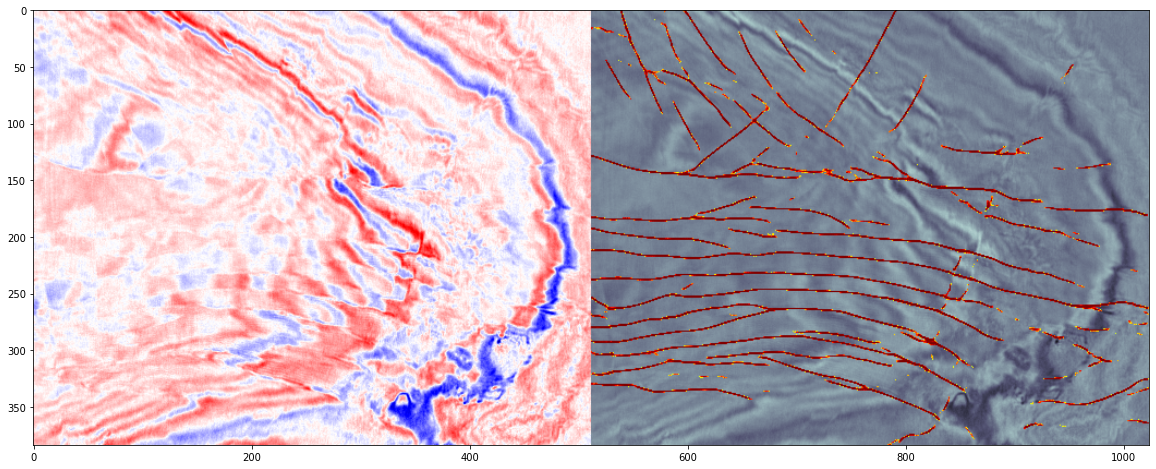

In [26]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
gx = normalization(gx)
k1,k2,k3 =88,95,32
tline_slice = gx[k1,:,:]
xline_slice = gx[:,:,k3]
#print(xline_slice.shape)
iline_slice = gx[:,k2,:]                                                            
tline_result = fp[k1,:,:]
xline_result = fp[:,:,k3]
iline_result = fp[:,k2,:]
tline_slice,tline_result = get_result_img(tline_slice,tline_result)
iline_slice,iline_result = get_result_img(iline_slice,iline_result)
xline_slice,xline_result = get_result_img(xline_slice,xline_result)
tline = np.concatenate((tline_slice,tline_result),1)
iline = np.concatenate((iline_slice,iline_result),1)
xline = np.concatenate((xline_slice,xline_result),1)
plt.figure(figsize=(20,8))
plt.imshow(tline,interpolation='bilinear'
,aspect='auto')

In [ ]:
f3_3d=get_result_img_3d(fp,gx)

In [ ]:
import draw
#f3_3d=get_result_img_3d(fp,gx)
draw.draw_slice(f3_3d, x_slice=30, y_slice=30, z_slice=120, cmap='grey')

In [28]:

f3 = np.load("/data/max/FaultNet-main/data/F3.npy").transpose((2, 1, 0))
clip_percentile = 99
vm = np.percentile(f3[:,:,:], clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {f3[:,:,55].max():.0f}'

'The 99th percentile is 7446; the max amplitude is 26005'

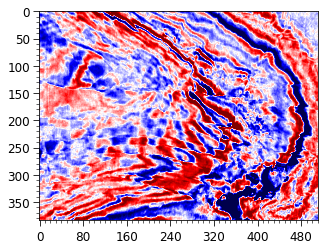

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(5,5))
xmajorLocator = MultipleLocator(80)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(50)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=12)
ax.tick_params(which='minor',length=3)
im=plt.imshow(f3[88,:,:],cmap="seismic",vmin=-vm,vmax=vm,interpolation="bilinear")

#plt.imshow(f3[:,:,32],cmap="seismic",vmin=-vm,vmax=vm,interpolation="bilinear")
plt.savefig("/data/max/3d-nets/3d_paper_v2/f3_88.png",dpi=300,bbox_inches='tight')

In [ ]:
f3_3d=get_result_img_3d(fp,gx)
np.save("/data/max/3d-nets/3d-paper/f3_r2seunet.npy",f3_3d)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl

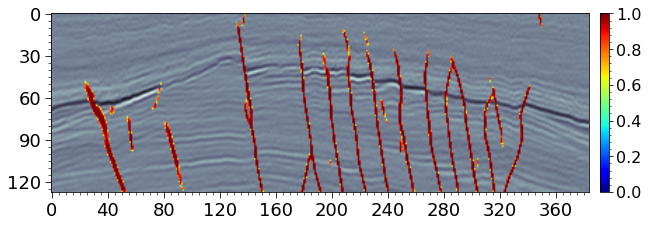

In [65]:
#=========实际地震数据，根据需要调整参数==============#
plt.figure(figsize=(10,10))
xmajorLocator = MultipleLocator(80)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(50)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=18)
ax.tick_params(which='minor',length=3)
im=plt.imshow(xline_result,cmap="jet",interpolation="bilinear")
clb=plt.colorbar(im,fraction=0.0160,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.tick_params(labelsize=16)
#plt.savefig("/data/max/3d-nets/3d_paper_new/diff_loss/f3_77_ce+dice.jpg",dpi=500)

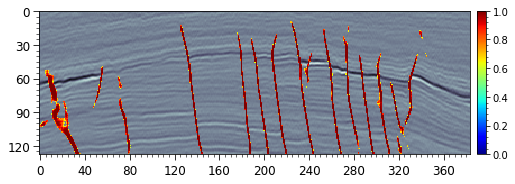

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(8,8))
xmajorLocator = MultipleLocator(40)
xminorLocator   = MultipleLocator(5)
ymajorLocator = MultipleLocator(30)
yminorLocator   = MultipleLocator(5)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=12)
ax.tick_params(which='minor',length=3)
im=plt.imshow(xline_result,cmap="jet",vmin=0,vmax=1,aspect="1")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
clb=plt.colorbar(im, cax=cax)
#clb=plt.colorbar(im,fraction=0.0161,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.tick_params(labelsize=10)
#plt.imshow(xline_result,vmax=0.9,vmin=0.2,cmap="bone")
plt.savefig("/data/max/3d-nets/3d_paper_v2/f3_32_compound.png",dpi=300,bbox_inches='tight')

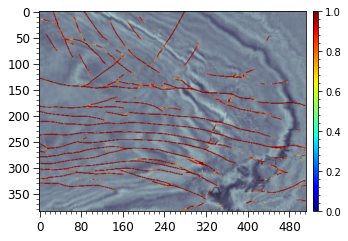

In [30]:
#=====================tline script====================#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(5,5))
xmajorLocator = MultipleLocator(80)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(50)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=12)
ax.tick_params(which='minor',length=3)
im=plt.imshow(tline_result,cmap="jet",vmin=0,vmax=1,aspect="1",interpolation="bilinear")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
clb=plt.colorbar(im, cax=cax)
#clb=plt.colorbar(im,fraction=0.0161,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.tick_params(labelsize=10)
#plt.imshow(xline_result,vmax=0.9,vmin=0.2,cmap="bone")
plt.savefig("/data/max/3d-nets/3d_paper_v2/f3_88_compound.png",dpi=300,bbox_inches='tight')

In [3]:
import matplotlib.pyplot as plt
import copy
%matplotlib inline
n1,n2,n3=272,192,608
kerry = np.load('/data/max/FaultNet-main/data/kerry1.npy').transpose((2,1, 0))
gx=copy.deepcopy(kerry)
gm = np.mean(gx)
gs = np.std(gx)
gx = gx-gm
gx = gx/gs
#gx = np.transpose(gx)
a=np.reshape(gx,(1,1,n1,n2,n3))
#a=torch.tensor(a)
a=torch.tensor(a)
#a=a.half()
model.eval()
fp = model(a)
fp = torch.sigmoid(fp).detach().cpu().numpy()
fp=fp.squeeze()
#fp[fp>0.5]=1

In [5]:
def get_result_img (geo_slice, result_slice):
    hm = plt.get_cmap('bone')(geo_slice)[:, :, :-1]
    geo_slice = plt.get_cmap('seismic')(geo_slice)[:, :, :-1]
    logits = np.clip((result_slice[:, :, None]), a_min=0, a_max=1)
    colormap = plt.get_cmap('jet')(logits[:, :, 0])[:, :, :-1]
    hm = np.where(logits > 0.6, colormap, hm)
    return geo_slice, hm
def get_result_img_3d (fp, gx):
    hm = np.where(fp > 0.8, fp, gx)
    return hm
def get_result_img_(geo_slice, result_slice):
    hm = plt.get_cmap('bone')(geo_slice)[:, :,:,:-1]
    geo_slice = plt.get_cmap('seismic')(geo_slice)[:, :,:,:-1]
    logits = np.clip((result_slice[:, :,:, None]), a_min=0, a_max=1)
    colormap = plt.get_cmap('jet')(logits[:, :,:, 0])[:, :, :,:-1]
    hm = np.where(logits > 0.5, colormap, hm)
    return geo_slice, hm

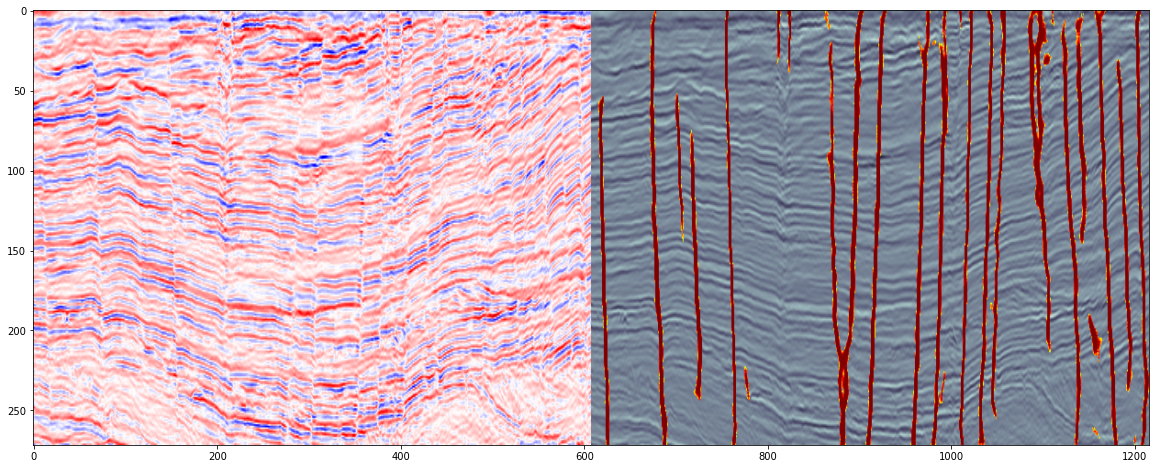

In [19]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
gx = normalization(gx)
k1,k2,k3 =89,97,91
tline_slice = gx[k1,:,:]
xline_slice = gx[:,:,k3]
iline_slice = gx[:,k2,:]
tline_result = fp[k1,:,:]
xline_result = fp[:,:,k3]
iline_result = fp[:,k2,:]
#iline_slice=np.load("/data/max/FaultNet-main/1.npy")
#iline_result=np.load("/data/max/auyu_code/SFD-CNN-TL/predictions/pidi_ft_smooth/1.npy")
tline_slice,tline_result = get_result_img(tline_slice,tline_result)
iline_slice,iline_result = get_result_img(iline_slice,iline_result)
xline_slice,xline_result = get_result_img(xline_slice,xline_result)
tline = np.concatenate((tline_slice,tline_result),1)
iline = np.concatenate((iline_slice,iline_result),1)
xline = np.concatenate((xline_slice,xline_result),1)
plt.figure(figsize=(20,8))
plt.imshow(iline,interpolation='bilinear',aspect='auto')

In [53]:
kerry = np.load('/data/max/FaultNet-main/data/kerry1.npy').transpose((2,1, 0))
print(kerry.min(),kerry.max())
clip_percentile = 99
vm = np.percentile(kerry, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {f3[:,:,55].max():.0f}'

0.0 1.0


'The 99th percentile is 1; the max amplitude is 26005'

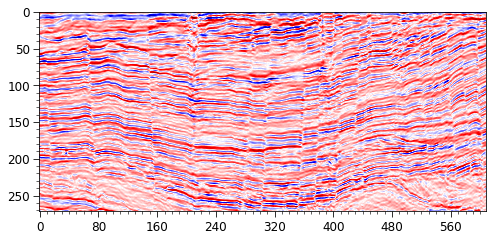

In [20]:
plt.figure(figsize=(8,6))
xmajorLocator = MultipleLocator(80)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(50)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=12)
ax.tick_params(which='minor',length=3)
im=plt.imshow(kerry[:,97,:],cmap="seismic",interpolation="bilinear",aspect="1",vmin=0.2,vmax=0.8)
#clb=plt.colorbar(im,fraction=0.0153,pad=0.02)
#colorminorLocator   = MultipleLocator(0.04)
#clb.ax.yaxis.set_minor_locator(colorminorLocator)
#clb.ax.tick_params(labelsize=16)
#plt.savefig("/data/max/3d-nets/3d_paper_v2/kerry_89.png",dpi=300,bbox_inches='tight')

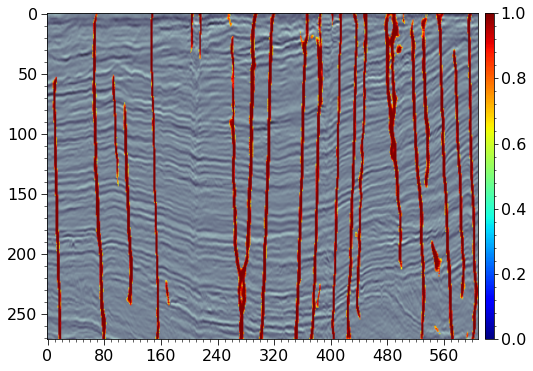

In [42]:
#======================iline====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(8,6))
xmajorLocator = MultipleLocator(80)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(50)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=16)
ax.tick_params(which='minor',length=3)
im=plt.imshow(iline_result,cmap="jet",vmin=0,vmax=1,aspect="auto",interpolation="bilinear")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
clb=plt.colorbar(im, cax=cax)
#clb=plt.colorbar(im,fraction=0.0161,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.tick_params(labelsize=16)
plt.savefig("/data/max/3d-nets/3d_paper_v2/kerry_97_compound.png",dpi=300,bbox_inches='tight')

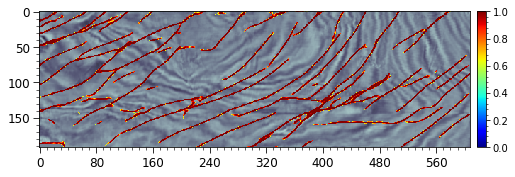

In [62]:
#======================tline====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(8,6))
xmajorLocator = MultipleLocator(80)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(50)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=12)
ax.tick_params(which='minor',length=3)
im=plt.imshow(tline_result,cmap="jet",vmin=0,vmax=1)
divider = make_axes_locatable(ax)#
cax = divider.append_axes("right", size="2%", pad=0.1)
clb=plt.colorbar(im, cax=cax)
#clb=plt.colorbar(im,fraction=0.0161,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
colormajorLocator   = MultipleLocator(0.2)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.yaxis.set_major_locator(colormajorLocator )
clb.ax.tick_params(labelsize=10)
plt.savefig("/data/max/3d-nets/3d_paper_v2/kerry_89_compound.png",dpi=300,bbox_inches='tight')

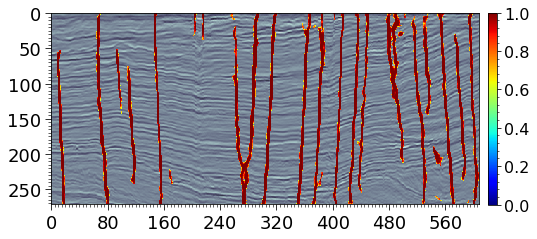

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(8,8))
xmajorLocator = MultipleLocator(80)
xminorLocator   = MultipleLocator(5)
ymajorLocator = MultipleLocator(50)
yminorLocator   = MultipleLocator(5)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=18)
ax.tick_params(which='minor',length=3)
im=plt.imshow(iline_result,cmap="jet")
clb=plt.colorbar(im,fraction=0.0215,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.tick_params(labelsize=16)
plt.savefig("/data/max/3d-nets/3d_paper_new/kerry_97_ce+dice.jpg",dpi=500)

In [8]:
gx = np.load('/data/max/FaultNet-main/data/kerry1.npy').transpose((2,1, 0))
gm = np.mean(gx)
gs = np.std(gx)
gx = gx-gm
gx = gx/gs
gx=np.clip(gx,-6,6)
f3_3d=get_result_img_3d(fp*6,gx)
np.save("/data/max/3d-nets/3d-paper/kerry_r2seunet.npy",f3_3d)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
n1,n2,n3=352,704,320
opunake=np.load("/data/max/3d-nets/opunake.npy")
gx=opunake
gm = np.mean(gx)
gs = np.std(gx)
gx = gx-gm
gx = gx/gs
#gx = np.transpose(gx)
a=np.reshape(gx,(1,1,n1,n2,n3))
#a=torch.tensor(a)
a=torch.tensor(a)
#a=a.half()
model.eval()
fp = model(a)
fp = torch.sigmoid(fp).detach().cpu().numpy()
fp=fp.squeeze()

In [4]:
def get_result_img (geo_slice, result_slice):
    hm = plt.get_cmap('bone')(geo_slice)[:, :, :-1]
    geo_slice = plt.get_cmap('seismic')(geo_slice)[:, :, :-1]
    logits = np.clip((result_slice[:, :, None]), a_min=0, a_max=1)
    colormap = plt.get_cmap('jet')(logits[:, :, 0])[:, :, :-1]
    hm = np.where(logits > 0.5, colormap, hm)
    return geo_slice, hm
def get_result_img_3d (fp, gx):
    hm = np.where(fp > 0.5, fp, gx)
    return hm

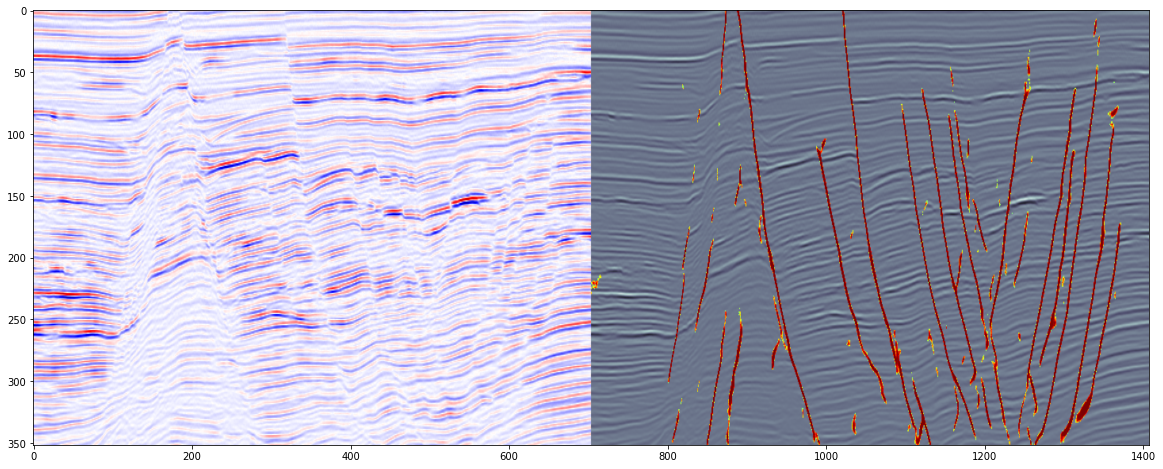

In [5]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
gx = normalization(gx)
k1,k2,k3 =210,146,89
tline_slice = gx[k1,:,:]
xline_slice = gx[:,:,k3]
#print(xline_slice.shape)
iline_slice = gx[:,k2,:]                                                            
tline_result = fp[k1,:,:]
xline_result = fp[:,:,k3]
iline_result = fp[:,k2,:]
tline_slice,tline_result = get_result_img(tline_slice,tline_result)
iline_slice,iline_result = get_result_img(iline_slice,iline_result)
xline_slice,xline_result = get_result_img(xline_slice,xline_result)
tline = np.concatenate((tline_slice,tline_result),1)
iline = np.concatenate((iline_slice,iline_result),1)
xline = np.concatenate((xline_slice,xline_result),1)
plt.figure(figsize=(20,8))
plt.imshow(xline,interpolation='bilinear'
,aspect='auto')

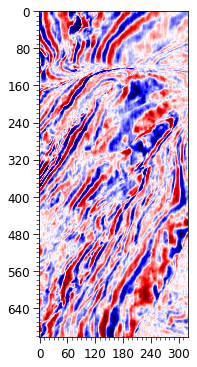

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
opunake=np.load("/data/max/3d-nets/opunake.npy")
clip_percentile = 99
vm = np.percentile(opunake, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {opunake[:,:,66].max():.0f}'
#plt.figure(figsize=(20,10))
plt.figure(figsize=(8,6))
xmajorLocator = MultipleLocator(60)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(80)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=12)
ax.tick_params(which='minor',length=3)
plt.imshow(opunake[210,:,:],vmin=-vm,vmax=vm,cmap="seismic",interpolation='bilinear')
plt.savefig("/data/max/3d-nets/3d_paper_v2/opunake_210.png",dpi=300,bbox_inches='tight')

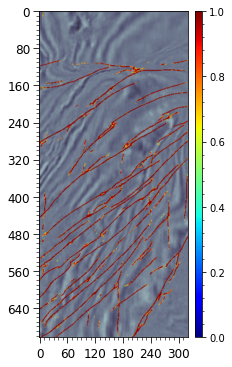

In [7]:
#===============tline===================##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(8,6))
xmajorLocator = MultipleLocator(60)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(80)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=12)
ax.tick_params(which='minor',length=3)
im=plt.imshow(tline_result,cmap="jet",vmin=0,vmax=1,interpolation="bilinear")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
clb=plt.colorbar(im, cax=cax)
#clb=plt.colorbar(im,fraction=0.0161,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
colormajorLocator   = MultipleLocator(0.2)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.yaxis.set_major_locator(colormajorLocator )
clb.ax.tick_params(labelsize=10)
plt.savefig("/data/max/3d-nets/3d_paper_v2/opunake_210_compound.png",dpi=300,bbox_inches='tight')

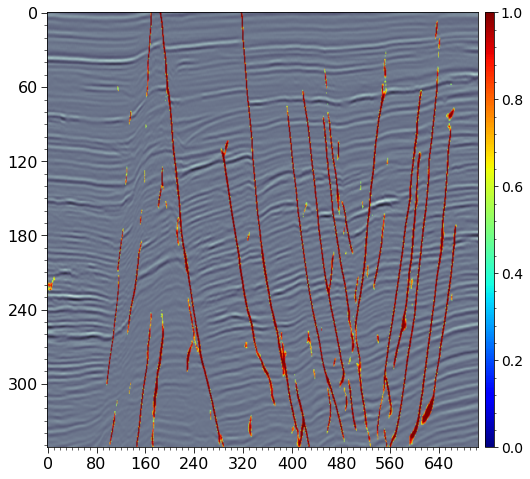

In [14]:
#===============xline===================##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(8,8))
xmajorLocator = MultipleLocator(80)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(60)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=16)
ax.tick_params(which='minor',length=3)
im=plt.imshow(xline_result,cmap="jet",vmin=0,vmax=1,interpolation="bilinear",aspect="auto")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)
clb=plt.colorbar(im, cax=cax)
#clb=plt.colorbar(im,fraction=0.0161,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
colormajorLocator   = MultipleLocator(0.2)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.yaxis.set_major_locator(colormajorLocator )
clb.ax.tick_params(labelsize=14)
plt.savefig("/data/max/3d-nets/3d_paper_v2/opunake_89_compound.png",dpi=300,bbox_inches='tight')

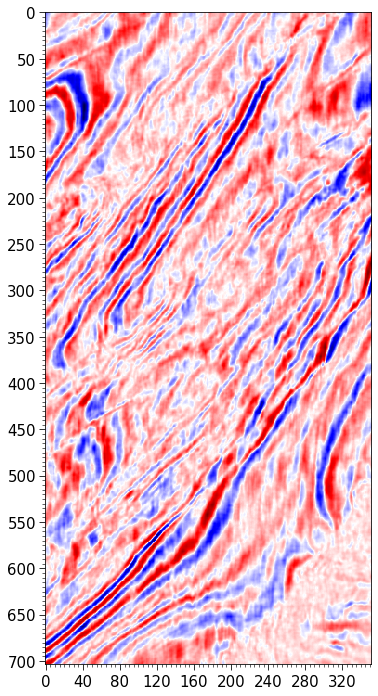

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(12,12))
xmajorLocator = MultipleLocator(40)
xminorLocator   = MultipleLocator(5)
ymajorLocator = MultipleLocator(50)
yminorLocator   = MultipleLocator(5)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=15)
ax.tick_params(which='minor',length=3)
im=plt.imshow(gx[k1,:,:],cmap="seismic")
plt.savefig("/data/max/3d-nets/3d-paper/diff_model/210.jpg",dpi=300)

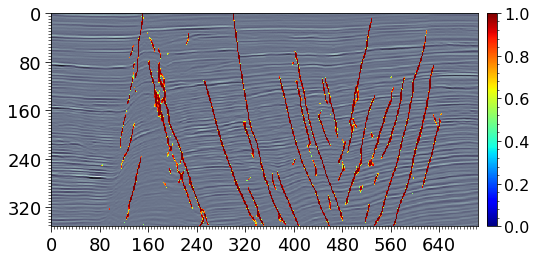

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(8,8))
xmajorLocator = MultipleLocator(80)
xminorLocator   = MultipleLocator(5)
ymajorLocator = MultipleLocator(80)
yminorLocator   = MultipleLocator(5)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=18)
ax.tick_params(which='minor',length=3)
im=plt.imshow(xline_result,cmap="jet")
clb=plt.colorbar(im,fraction=0.0239,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.tick_params(labelsize=16)
plt.savefig("/data/max/3d-nets/3d_paper_new/diff_loss/opunake_123_ce+dice.jpg",dpi=500)

In [ ]:
opunake=get_result_img_3d(fp,gx)
np.save("/data/max/3d-nets/3d-paper/opunake_r2seunet.npy",opunake)

In [ ]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

# GSB

In [3]:
import matplotlib.pyplot as pl
import copy
%matplotlib inline
n1,n2,n3=192,576,256#192,576,256(gsb)192,640,320(gsb_2)
gsb=np.load("/data/max/3d-nets/gsb.npy")
gx=gsb
gm = np.mean(gx)
gs = np.std(gx)
gx = gx-gm
gx = gx/gs
#gx = np.transpose(gx)
a=np.reshape(gx,(1,1,n1,n2,n3))
#a=torch.tensor(a)
a=torch.tensor(a)
#a=a.half()
model.eval()
fp = model(a)
fp = torch.sigmoid(fp).detach().cpu().numpy()
fp=fp.squeeze()

In [4]:
def get_result_img (geo_slice, result_slice):
    hm = plt.get_cmap('bone')(geo_slice)[:, :, :-1]
    geo_slice = plt.get_cmap('seismic')(geo_slice)[:, :, :-1]
    logits = np.clip((result_slice[:, :, None]), a_min=0, a_max=1)
    colormap = plt.get_cmap('jet')(logits[:, :, 0])[:, :, :-1]
    hm = np.where(logits > 0.5, colormap, hm)
    return geo_slice, hm
def get_result_img_3d (fp, gx):
    hm = np.where(fp > 0.5, fp, gx)
    return hm

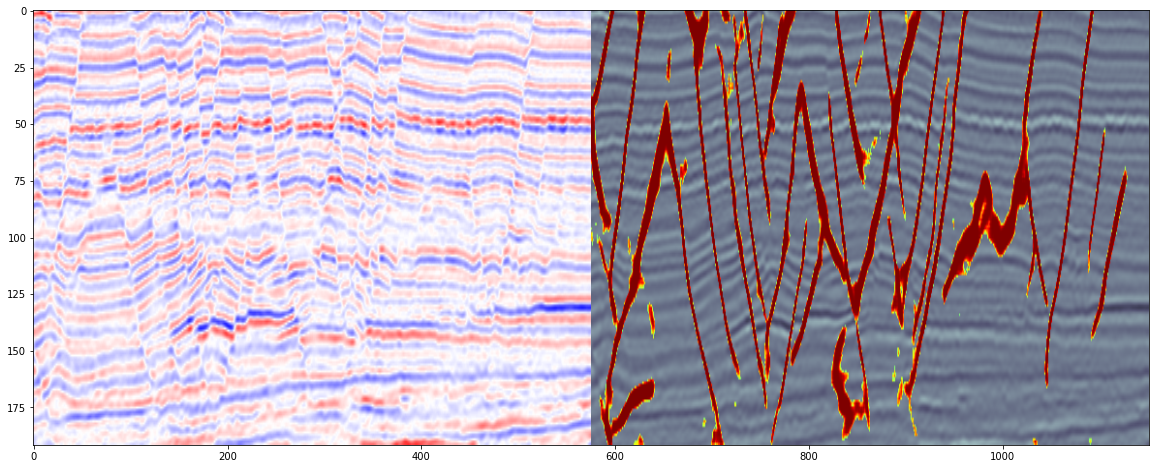

In [7]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
gx = normalization(gx)
k1,k2,k3 =100,155,20
tline_slice = gx[k1,:,:]
xline_slice = gx[:,:,k3]
#print(xline_slice.shape)
iline_slice = gx[:,k2,:]                                                            
tline_result = fp[k1,:,:]
xline_result = fp[:,:,k3]
iline_result = fp[:,k2,:]
tline_slice,tline_result = get_result_img(tline_slice,tline_result)
iline_slice,iline_result = get_result_img(iline_slice,iline_result)
xline_slice,xline_result = get_result_img(xline_slice,xline_result)
tline = np.concatenate((tline_slice,tline_result),1)
iline = np.concatenate((iline_slice,iline_result),1)
xline = np.concatenate((xline_slice,xline_result),1)
plt.figure(figsize=(20,8))
plt.imshow(xline,interpolation='bilinear'
,aspect='auto')

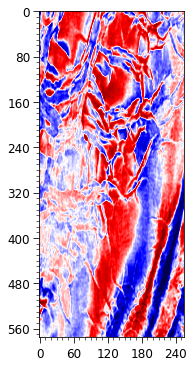

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
gsb=np.load("/data/max/3d-nets/gsb.npy")
clip_percentile = 99
vm = np.percentile(gsb, clip_percentile)
#plt.figure(figsize=(20,10))
plt.figure(figsize=(8,6))
xmajorLocator = MultipleLocator(60)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(80)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=12)
ax.tick_params(which='minor',length=3)
plt.imshow(gsb[100,:,:],vmin=-vm,vmax=vm,cmap="seismic",interpolation='bilinear')
plt.savefig("/data/max/3d-nets/3d_paper_v2/gbs_100.png",dpi=300,bbox_inches='tight')

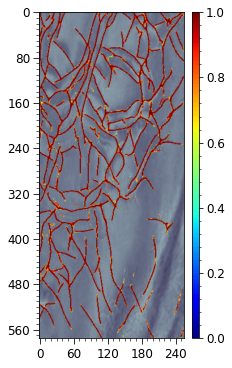

In [7]:
#===============tline===================##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(8,6))
xmajorLocator = MultipleLocator(60)
xminorLocator   = MultipleLocator(10)
ymajorLocator = MultipleLocator(80)
yminorLocator   = MultipleLocator(10)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=12)
ax.tick_params(which='minor',length=3)
im=plt.imshow(tline_result,cmap="jet",vmin=0,vmax=1,interpolation="bilinear")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
clb=plt.colorbar(im, cax=cax)
#clb=plt.colorbar(im,fraction=0.0161,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
colormajorLocator   = MultipleLocator(0.2)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.yaxis.set_major_locator(colormajorLocator )
clb.ax.tick_params(labelsize=12)
plt.savefig("/data/max/3d-nets/3d_paper_v2/gbs_100_compound.png",dpi=300,bbox_inches='tight')

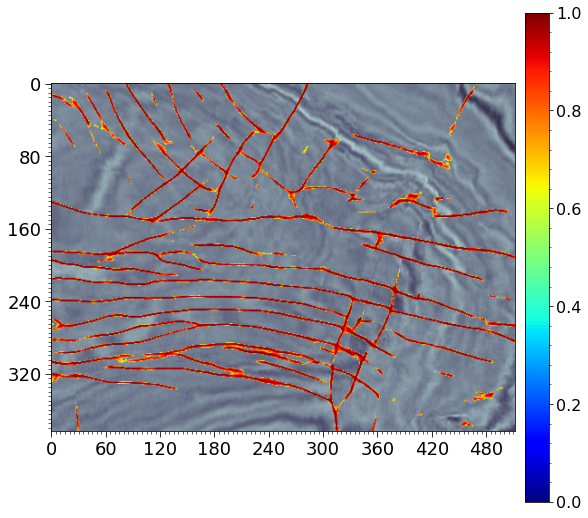

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
plt.figure(figsize=(9,9))
xmajorLocator = MultipleLocator(60)
xminorLocator   = MultipleLocator(5)
ymajorLocator = MultipleLocator(80)
yminorLocator   = MultipleLocator(5)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=18)
ax.tick_params(which='minor',length=3)
im=plt.imshow(tline_result,cmap="jet",aspect="1",interpolation="bilinear")
clb=plt.colorbar(im,fraction=0.0565,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.tick_params(labelsize=16)
#plt.savefig("/data/max/3d-nets/3d_paper_new/GBS_20_r2se.jpg",dpi=500)

In [32]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=<deprecated parameter>, filternorm=1, filterrad=4.0, imlim=<deprecated parameter>, resample=None, url=None, *, data=None, **kwargs)
    Display an image, i.e. data on a 2D regular raster.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The data is visualized
          using a colormap.
        - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
        - (M, N, 4): an image with RGBA values (0-1 float or 0-255 int),
          i.e. including transparency.
    
        The first two dimensions (M, N) define the rows and columns of
        the image.
    
        Out-of-range RGB(A) values are clipped.
    
    cmap : str or `~matplotlib.colors.Colormap`, optional
        The 

In [ ]:
plt.figure(figsize=(10,10))
xmajorLocator = MultipleLocator(40)
xminorLocator   = MultipleLocator(5)
ymajorLocator = MultipleLocator(50)
yminorLocator   = MultipleLocator(5)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=15)
ax.tick_params(which='minor',length=3)
im=plt.imshow(tline_result,cmap="jet")
clb=plt.colorbar(im,fraction=0.08,pad=0.02)
colorminorLocator   = MultipleLocator(0.04)
clb.ax.yaxis.set_minor_locator(colorminorLocator)
clb.ax.tick_params(labelsize=16)
#plt.savefig("/data/max/3d-nets/3d-paper/diff_model/r2se_20.jpg",dpi=500)

In [ ]:
gsb=get_result_img_3d(fp,gx)
np.save("/data/max/3d-nets/3d-paper/gsb_ce+gdice.npy",gsb)

In [ ]:
gsb[:,k2,:].max()

In [25]:
gsb=np.load("/data/max/3d-nets/gsb_2.npy")
clip_percentile = 99
vm = np.percentile(gsb, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {gsb.max():.0f}'

'The 99th percentile is 8332; the max amplitude is 35628'

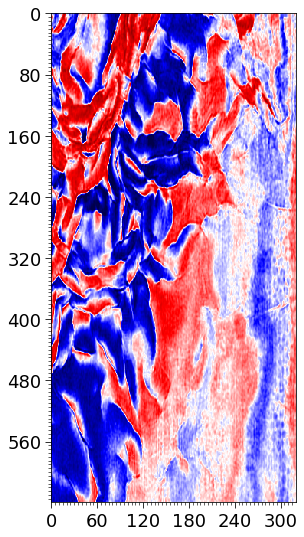

In [41]:
plt.figure(figsize=(9,9))
xmajorLocator = MultipleLocator(60)
xminorLocator   = MultipleLocator(5)
ymajorLocator = MultipleLocator(80)
yminorLocator   = MultipleLocator(5)
ax=plt.axes()
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.tick_params(which='major',length=6,labelsize=18)
ax.tick_params(which='minor',length=3)
plt.imshow(gsb[20,:,:],cmap="seismic",vmin=-vm,vmax=vm,aspect="1")
plt.savefig("/data/max/3d-nets/3d_paper_new/GBS_20.jpg",dpi=500)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(xline_result,aspect="auto")